In [1]:
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pymc as pm 

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Data

In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv")

In [3]:
data.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [4]:
y = data['medv']
X = data.drop(columns=['medv'])

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Bayesian Linear Regression

\begin{align*}
    y^{(i)} &= \beta_0 +  x_1^{(i)}\beta_1 + x_2^{(i)}\beta_2 + \dots + x_p^{(i)}\beta_p + \varepsilon^{(i)} \\ 
    \underset{n \times 1}{\begin{bmatrix}
        y^{(1)} \\
        y^{(2)}\\
        y^{(3)} \\ 
        \vdots \\
        y^{(n)}
    \end{bmatrix}} &= \underset{n \times (p+1)}{\begin{bmatrix}
1 & x_1^{(1)} & x_2^{(1)} & \dots & x_p^{(1)} \\
1 & x_1^{(2)} & x_2^{(2)} & \dots & x_p^{(2)} \\
1 & x_1^{(3)} & x_2^{(3)} & \dots & x_p^{(3)} \\
\vdots & \vdots & \vdots & \dots & \vdots \\
1 & x_1^{(n)} & x_2^{(n)} & \dots & x_p^{(n)}
\end{bmatrix}} \underset{(p +1) \times 1}{\begin{bmatrix}
    \beta_0 \\ 
    \beta_1 \\ 
    \beta_2 \\ 
    \vdots \\
    \beta_p
\end{bmatrix}} + \underset{n \times 1}{\begin{bmatrix}
    \varepsilon^{(1)} \\ 
    \varepsilon^{(2)} \\ 
    \varepsilon^{(3)} \\ 
    \vdots \\
    \varepsilon^{(n)}
\end{bmatrix}} \\
\mathbf{y} &= \mathbf{X}\boldsymbol{\beta} + \boldsymbol{\varepsilon}
\end{align*}

$$ Y \sim \mathcal{N}(X\beta, \sigma^2)$$

In [6]:
coords = {
    "betas": X.columns,  
   # "obs_id": np.arange(X_train.shape[0])
}

In [7]:
with pm.Model(coords=coords) as linear_reg:

    X_data = pm.MutableData("X_data", X_train.values, dims=("obs_id","betas"))
    y_data = pm.MutableData("y_data", y_train.values, dims="obs_id")

    # priors
    nu    = pm.Exponential("nu", 1/30)
    beta  = pm.StudentT("beta", mu=0, sigma=1, nu=nu, dims="betas")
    alpha = pm.StudentT("Intercept", mu=0, sigma=5, nu=3)
    sigma = pm.HalfStudentT("sigma", nu=3, sigma=1)

    mu = alpha + pm.math.dot(X_data, beta)
    y_obs = pm.Normal("y", mu=mu, sigma=sigma, observed=y_data, dims="obs_id")

    idata = pm.sample(nuts_sampler="numpyro", draws=2000, tune=1000, return_inferencedata=True, progressbar=False)

/Users/stevenfiore/Bayesian Statistics/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
with linear_reg:
    posterior_predictive = pm.sample_posterior_predictive(idata)
    ppc   = pm.sample_posterior_predictive(idata, var_names=["y"])
    
idata.extend(posterior_predictive)

Sampling: [y]


Sampling: [y]


## Posterior Predictive Check

In [9]:
from posterior_predictive_plots import plot_posterior_predictive_distribution, plot_posterior_predictive_comparison

(<Figure size 1200x800 with 4 Axes>, array([ 70, 218, 384,  33]))

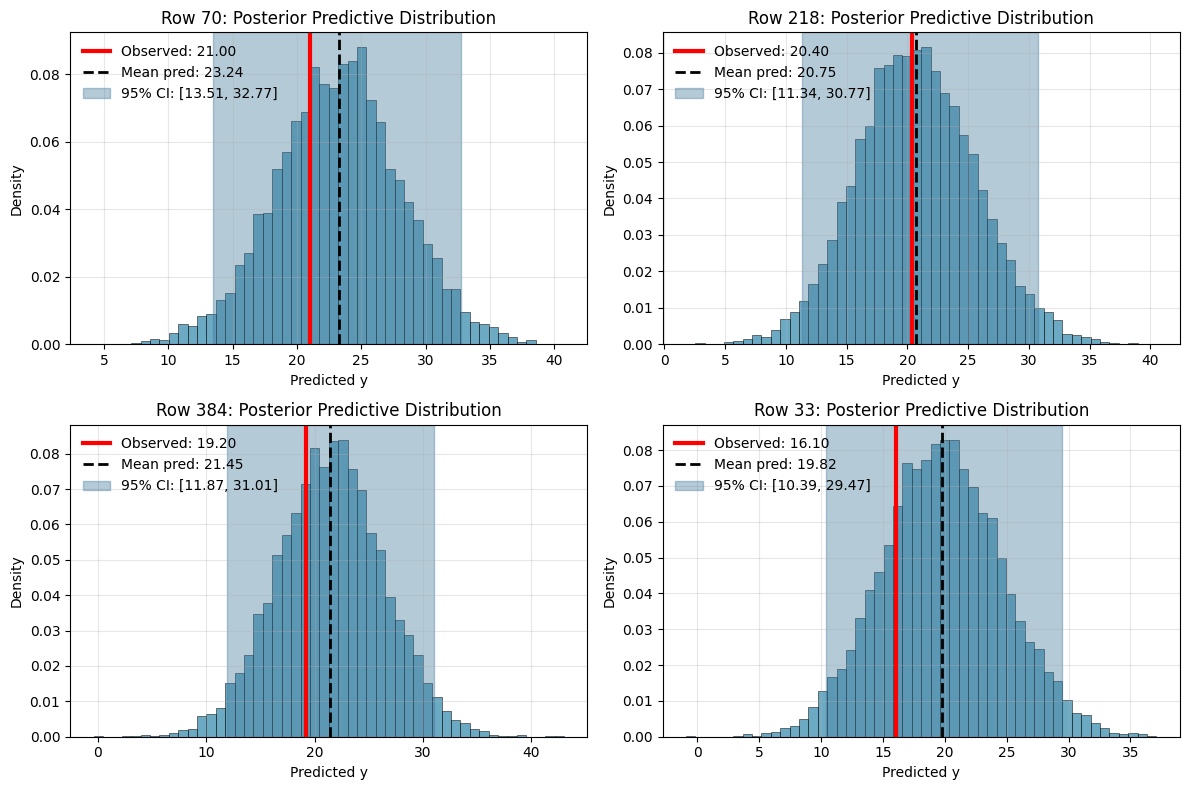

In [10]:
plot_posterior_predictive_distribution(idata, random_seed=42)

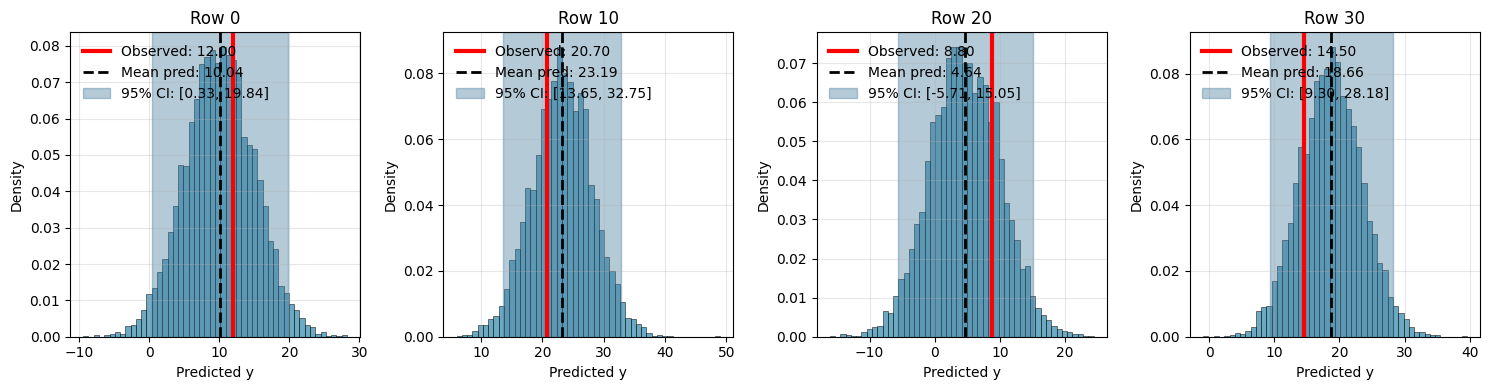

In [11]:
plot_posterior_predictive_comparison(idata, row_indices=[0, 10, 20, 30])

# Performance Metrics: Bayesian GLM

In [12]:
from regression_metrics import print_regression_metrics

## In-sample

In [13]:
y_ppc_train = (
    idata
    .posterior_predictive["y"]
    .stack(sample=("chain","draw"))
    .values    # now shape = (n_samples, n_obs)
)
y_pred_mean_insample = y_ppc_train.mean(axis=1)   

In [14]:
print_regression_metrics(y_train, y_pred_mean_insample, prefix="")

MSE: 22.2221
RMSE: 4.7140
MAE: 3.2920
R²: 0.7442


## Out-of-sample

In [15]:
with linear_reg:
    pm.set_data({
      "X_data": X_test.values,
      "y_data": y_test.values
    })
    ppc_test = pm.sample_posterior_predictive(idata, var_names=["y"])


Sampling: [y]


In [16]:
y_ppc_test = (
    ppc_test
    .posterior_predictive["y"]
    .stack(sample=("chain","draw"))
    .values    # now shape = (n_samples, n_obs)
)
y_pred_mean_oos = y_ppc_test.mean(axis=1)   

In [17]:
print_regression_metrics(y_test, y_pred_mean_oos, prefix="")

MSE: 25.3137
RMSE: 5.0313
MAE: 3.1603
R²: 0.6548


## OLS

In [18]:
import statsmodels.api as sm
from statsmodels.api import OLS

In [19]:
ols_model = OLS(y_train, sm.add_constant(X_train)).fit()  

In [20]:
print_regression_metrics(y_train, ols_model.predict(sm.add_constant(X_train)), prefix="")

MSE: 21.6414
RMSE: 4.6520
MAE: 3.3148
R²: 0.7509


In [21]:
print_regression_metrics(y_test, ols_model.predict(sm.add_constant(X_test)), prefix="")

MSE: 24.2911
RMSE: 4.9286
MAE: 3.1891
R²: 0.6688


## BART

$$ Y \sim f(X) + \varepsilon $$ 
where $f$ is the sum of $m$ regression trees and $\varepsilon \sim \mathcal N(0, \sigma)$. More specifically, 
$$ f(X) = \sum_{j=1}^{m} T_j(X;\,\mathcal T_j, \mathcal M_j)$$ 
with each tree $T_j$ defined by its binary splitting rules $\mathcal T_j$ and leaf‐node parameters $\mathcal M_j$.  In BART, we place priors that favor small, shallow trees (so each contributes only a little), and Gaussian priors on the leaf values.  Posterior inference then proceeds by a backfitting MCMC: at each iteration you cycle through the m trees, updating one tree’s structure and terminal‐node means conditional on the residuals from all the others.  The result is a fully Bayesian ensemble that yields not only a flexible nonparametric fit but also coherent uncertainty intervals for predictions via the posterior draws of the tree sum.

In [22]:
import pymc_bart as pmb

In [23]:
with pm.Model() as bart_model:
    X = pm.MutableData("X", X_train, dims=("obs_id", "features"))
    sigma = pm.HalfNormal("sigma", sigma=10)
    
    mu = pmb.BART("mu", X, y_train, m=50)  

    y_obs = pm.Normal("y", mu=mu, sigma=sigma, observed=y_train, dims="obs_id")

    idata_bart = pm.sample()

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [sigma]
>PGBART: [mu]
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


## Posterior Predictive Check: BART

In [24]:
with bart_model:
    posterior_predictive = pm.sample_posterior_predictive(idata_bart)
    ppc   = pm.sample_posterior_predictive(idata_bart, var_names=["y"])

idata_bart.extend(ppc)

Sampling: [y]


Sampling: [y]


(<Figure size 1200x800 with 4 Axes>, array([ 70, 218, 384,  33]))

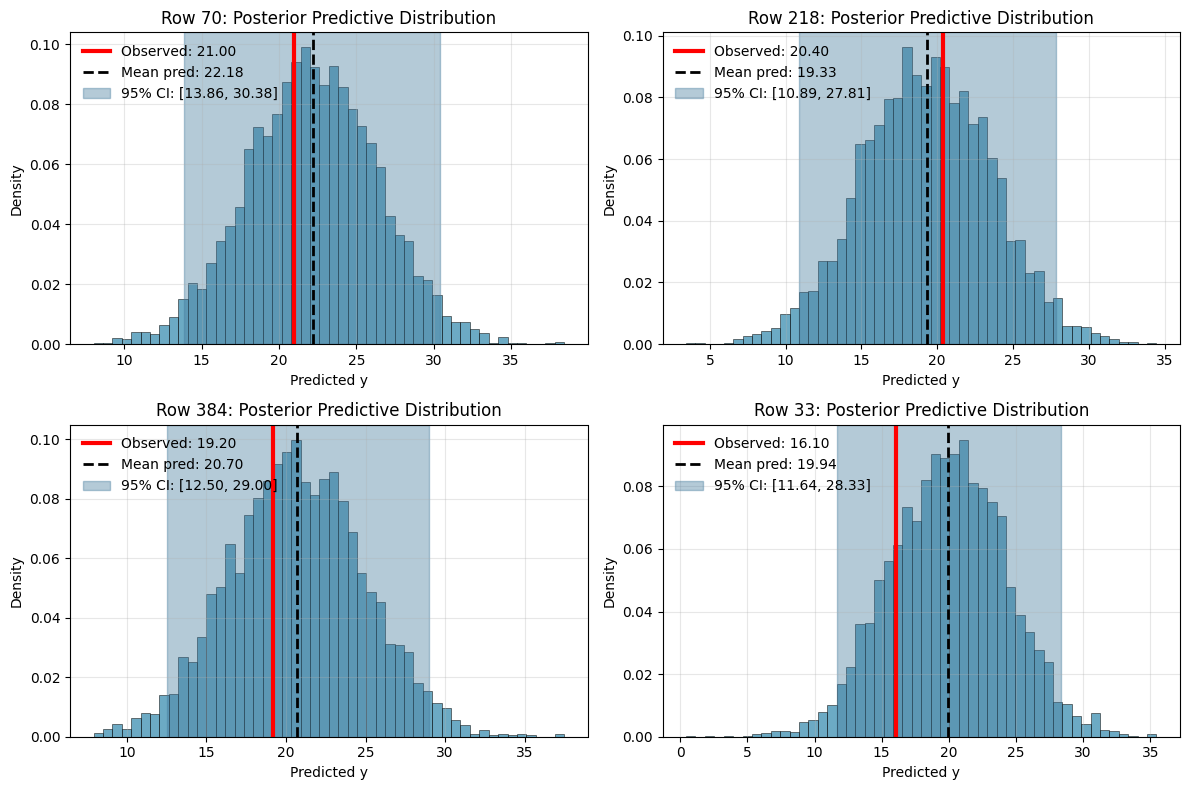

In [25]:
plot_posterior_predictive_distribution(idata_bart, random_seed=42)

# Performance Metrics: BART

## In-Sample

In [26]:
y_ppc_train = (
    idata_bart
    .posterior_predictive["y"]
    .stack(sample=("chain","draw"))
    .values    # now shape = (n_samples, n_obs)
)
y_pred_mean_insample = y_ppc_train.mean(axis=1)   

In [27]:
print_regression_metrics(y_train, y_pred_mean_insample, prefix="")

MSE: 12.9730
RMSE: 3.6018
MAE: 2.4924
R²: 0.8507


## Out-of-Sample

In [28]:
with bart_model:
    pm.set_data({
      "X": X_test.values
    })
    ppc_test = pm.sample_posterior_predictive(idata_bart, var_names=["y"])


Sampling: [mu, y]


In [29]:
y_ppc_test = (
    ppc_test
    .posterior_predictive["y"]
    .stack(sample=("chain","draw"))
    .values    # now shape = (n_samples, n_obs)
)
y_pred_mean_oos = y_ppc_test.mean(axis=1)   

In [30]:
print_regression_metrics(y_test, y_pred_mean_oos, prefix="")

MSE: 15.1514
RMSE: 3.8925
MAE: 2.2877
R²: 0.7934
